# UMI shoeboxer & results testing

In [1]:
from umi.ubem import UBEM
from utils.constants import *

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import geopandas as gpd
from ladybug.epw import EPW
from archetypal import UmiTemplateLibrary
import h5py


c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.8.16
[Taichi] Starting on arch=cuda


## 1. Open and build umi shoeboxes from .umi (unsimulated)

## or 2. Load from gdf, epw, and template_lib directly

In [2]:
gdf = gpd.read_file(Path("data") / "gis" / "Florianopolis_Baseline.zip")

# dict to store key fields for known gis files
id_cols = {
    "height_col": "HEIGHT",
    "id_col": "OBJECTID",
    "template_name_col": "template_name",
    "wwr_col": "wwr",
}

epw_fp = (
    Path("data")
    / "epws"
    / "global_epws_indexed"
    / "cityidx_0033_BRA_SP-São Paulo-Congonhas AP.837800_TRY Brazil.epw"
)

epw = EPW(epw_fp)
template_lib = UmiTemplateLibrary.open(
    Path("data") / "template_libs" / "BostonTemplateLibrary.json"
)

# Insert dummy template names
gdf[id_cols["template_name_col"]] = np.random.choice(
    [t.Name for t in template_lib.BuildingTemplates], size=gdf.shape[0]
)
# insert dummy wwrs
gdf[id_cols["wwr_col"]] = 0.4

umi_test = UBEM(
    gdf=gdf,
    **id_cols,
    epw=epw,
    template_lib=template_lib,
    shoebox_width=3,
    floor_to_floor_height=4,
    perim_offset=PERIM_OFFSET,
)

print("SCHEDULES ARRAY: ", umi_test.schedules_array.shape)
print("TEMPLATE DF: ", umi_test.template_features_df.shape)
print("EPW ARRAY: ", umi_test.epw_array.shape)

# TODO:
# Shading vector / RayTracing
# mapping
# using numerics for orientation instead of words?
# infiltration/ventilation etc

DEBUG:UMI:Fetching BuildingTemplate vector data from B_Off_0
DEBUG:UMI:Found facade with r_value 2.06 and tmass bin 1
DEBUG:UMI:Found slab with r_value 0.71
DEBUG:UMI:Found roof with r_value 3.25 and tmass bin 0
DEBUG:UMI:Fetching BuildingTemplate vector data from B_Ret_0
DEBUG:UMI:Found facade with r_value 2.06 and tmass bin 1
DEBUG:UMI:Found slab with r_value 0.71
DEBUG:UMI:Found roof with r_value 3.25 and tmass bin 0
DEBUG:UMI:Fetching BuildingTemplate vector data from B_Res_0_Masonry
DEBUG:UMI:Found facade with r_value 2.06 and tmass bin 1
DEBUG:UMI:Found slab with r_value 0.71
DEBUG:UMI:Found roof with r_value 3.3 and tmass bin 1
DEBUG:UMI:Fetching BuildingTemplate vector data from B_Res_0_WoodFrame
DEBUG:UMI:Found facade with r_value 2.84 and tmass bin 3
DEBUG:UMI:Found slab with r_value 0.71
DEBUG:UMI:Found roof with r_value 3.3 and tmass bin 1
INFO:Radiation Analysis:Beginning sky matrix extraction...
INFO:Radiation Analysis:Building Count: 93
INFO:Radiation Analysis:Approximat

SCHEDULES ARRAY:  (4, 3, 8760)
TEMPLATE DF:  (4, 27)
EPW ARRAY:  (7, 8760)


In [2]:
umi_test = UBEM.open_umi(
    filename="D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/Florianopolis_Baseline_unsimulated.umi",
)

INFO:UMI:reading input file...
DEBUG:UMI:TEMPORARY LOCATION C:\Users\zoelh\AppData\Local\Temp\tmpvvpei44b
INFO:UMI:Successfully loaded EPW file Data for [Florianópolis]
INFO:UMI:Opening archetpal templates at template-library.json
INFO:UMI:Read 18.1KB from D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/Florianopolis_Baseline_unsimulated.umi in 0.82 seconds
DEBUG:UMI:Fetching BuildingTemplate vector data from RefBldgFullServiceRestaurantPost1980_v1.4_7.2_2A_USA_TX_HOUSTON
DEBUG:UMI:Found facade with r_value 3.76 and tmass bin 2
DEBUG:UMI:Found slab with r_value 0.08
DEBUG:UMI:Found roof with r_value 0.06 and tmass bin 3
DEBUG:UMI:Using internal shgc calculation.
DEBUG:UMI:Fetching BuildingTemplate vector data from RefBldgMediumOfficeNew2004_v1.4_7.2_2A_USA_TX_HOUSTON
DEBUG:UMI:Found facade with r_value 2.6 and tmass bin 3
DEBUG:UMI:Found slab with r_value 0.28
DEBUG:UMI:Found roof with r_value 3.53 and tmass bin 2
DEBUG:UMI:Using internal shgc calculation

In [4]:
# TODO: WHY ARE THE NUMBER OF SBS DIFFERENT?
print(umi_test.shoeboxes_df.shape)
umi_test.shoeboxes_df.head()

(844, 62)


,building_id,orientation,roof_2_footprint,ground_2_footprint,floor_name,wwr,height,footprint_area,core_2_perim,floor_2_facade,...,shading_3,shading_4,shading_5,shading_6,shading_7,shading_8,shading_9,shading_10,shading_11,ach
0,8871aa84-b57c-9a46-a2ef-ccb8edbbac00,east,0.0,1.0,bottom,0.4,33.6,255.916544,0.623828,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149
1,8871aa84-b57c-9a46-a2ef-ccb8edbbac00,east,0.0,0.0,middle,0.4,33.6,255.916544,0.623828,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149
2,8871aa84-b57c-9a46-a2ef-ccb8edbbac00,east,1.0,0.0,top,0.4,33.6,255.916544,0.623828,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149
4,8871aa84-b57c-9a46-a2ef-ccb8edbbac00,north,0.0,1.0,bottom,0.4,33.6,255.916544,0.623828,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149
5,8871aa84-b57c-9a46-a2ef-ccb8edbbac00,north,0.0,0.0,middle,0.4,33.6,255.916544,0.623828,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149


In [5]:
umi_test.shoeboxes_df.describe()[
    [
        "Infiltration",
        "roof_2_footprint",
        "ground_2_footprint",
        "wwr",
        "height",
        "footprint_area",
        "core_2_perim",
        "floor_2_facade",
        "floor_count",
    ]
]

,Infiltration,roof_2_footprint,ground_2_footprint,wwr,height,footprint_area,core_2_perim,floor_2_facade,floor_count
count,844.000000,844.000000,844.000000,844.0,844.000000,844.000000,844.000000,844.0,844.000000
mean,0.000156,0.440758,0.440758,0.4,10.565877,166.898547,0.241197,1.0,3.654028
std,0.000102,0.496772,0.496772,0.0,8.029174,120.428985,0.297714,0.0,2.595501
min,0.000018,0.000000,0.000000,0.4,3.000000,22.762933,0.000000,1.0,1.000000
25%,0.000056,0.000000,0.000000,0.4,5.600000,74.471680,0.000000,1.0,2.000000
50%,0.000170,0.000000,0.000000,0.4,8.400000,132.922357,0.137030,1.0,3.000000
75%,0.000233,1.000000,1.000000,0.4,11.200000,212.512622,0.365526,1.0,4.000000
max,0.000379,1.000000,1.000000,0.4,36.400000,486.254367,1.091570,1.0,12.000000


C:\Users\zoelh\AppData\Local\Temp\ipykernel_659920\1817856785.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


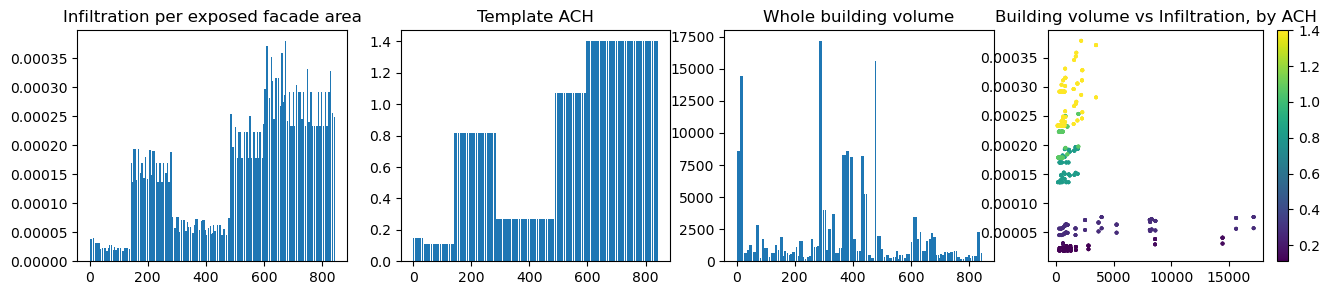

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
x = np.arange(umi_test.shoeboxes_df.shape[0])
ax[0].bar(x, umi_test.shoeboxes_df["Infiltration"], label="Shoebox")
ax[0].set_title("Infiltration per exposed facade area")
ax[1].bar(x, umi_test.shoeboxes_df["ach"])
ax[1].set_title("Template ACH")
v = umi_test.shoeboxes_df["footprint_area"] * umi_test.shoeboxes_df["height"]
ax[2].bar(x, v)
ax[2].set_title("Whole building volume")
# form_factor = (umi_test.shoeboxes_df['building_perimeter'] * umi_test.shoeboxes_df['height'] + 2*umi_test.shoeboxes_df['footprint_area'])/(umi_test.shoeboxes_df['footprint_area']*umi_test.shoeboxes_df['floor_count'])
im = ax[3].scatter(
    v, umi_test.shoeboxes_df["Infiltration"], s=3, c=umi_test.shoeboxes_df["ach"]
)
fig.colorbar(im, ax=ax[3])
ax[3].set_title("Building volume vs Infiltration, by ACH")
fig.show()

In [7]:
umi_test.building_gdf.head()


,geometry,HEIGHT,guid,TemplateName,WindowToWallRatioN,template_idx,cores,N_FLOORS,ARCHETYPE_ID
0,"POLYGON ((87.29775 128.23957, 97.61368 137.498...",33.6,8871aa84-b57c-9a46-a2ef-ccb8edbbac00,RefBldgMidriseApartmentNew2004_v1.4_7.2_2A_USA...,0.4,2,"POLYGON ((-19.07577 15.69957, -13.18029 20.990...",12.0,RefBldgMidriseApartmentNew2004_v1.4_7.2_2A_USA...
1,"POLYGON ((110.12728 189.09261, 118.83765 196.2...",5.6,6b9bb478-9313-f249-8aa8-8faaf46b84bc,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,0.4,4,"POLYGON ((3.58619 76.23407, 7.81345 79.69091, ...",2.0,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...
2,"POLYGON ((168.94178 70.19712, 198.67465 97.054...",5.6,41391093-5407-0a43-9cc6-312e66fcdd76,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...,0.4,0,POLYGON EMPTY,2.0,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...
3,"POLYGON ((69.18483 120.62694, 82.84475 132.307...",11.2,c01d47eb-099f-d548-b919-f634261aff69,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...,0.4,0,"POLYGON ((-37.09808 8.06901, -28.04000 15.8147...",4.0,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...
4,"POLYGON ((108.46445 136.16022, 123.31712 149.6...",3.0,739cd930-929f-f446-9cbd-1057856e207c,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...,0.4,0,"POLYGON ((2.10715 23.66572, 6.88553 28.02053, ...",1.0,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...


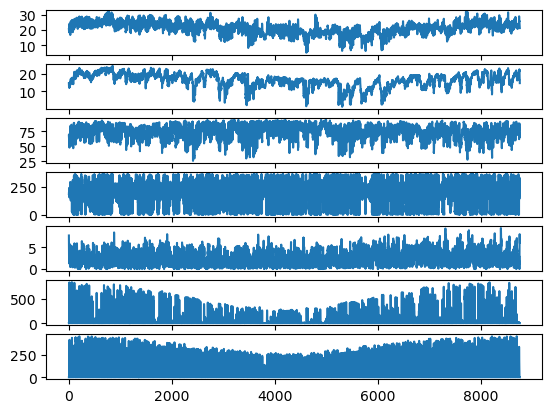

In [8]:
fig, ax = plt.subplots(umi_test.epw_array.shape[0], 1)
for i, row in enumerate(umi_test.epw_array):
    ax[i].plot(row)
plt.show()


In [9]:
print(umi_test.schedules_array.shape)
print(umi_test.schedules_array.min())
print(umi_test.schedules_array.max())


(6, 3, 8760)
0.0
0.966


In [10]:
umi_test.template_features_df


,PeopleDensity,LightingPowerDensity,EquipmentPowerDensity,Infiltration,VentilationPerArea,VentilationPerPerson,VentilationMode,HeatingSetpoint,CoolingSetpoint,humid_max,...,FacadeRValue,FacadeMass,RoofRValue,RoofMass,SlabRValue,WindowShgc,WindowUValue,visible_transmittance,TemplateName,template_idx
RefBldgFullServiceRestaurantPost1980_v1.4_7.2_2A_USA_TX_HOUSTON,0.538,24.4,475.0,0.816,0.0,0.0,MechVentMode.OccupancySchedule,20.5,24.5,81,...,3.763996,ThermalMassConstructions.WoodFrame,0.062544,ThermalMassConstructions.SteelFrame,0.077803,1.0,5.823529,0.8,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...,0
RefBldgMediumOfficeNew2004_v1.4_7.2_2A_USA_TX_HOUSTON,0.0538,10.8,19.0,0.271,0.0,0.0,MechVentMode.OccupancySchedule,21.0,24.0,81,...,2.600731,ThermalMassConstructions.SteelFrame,3.531932,ThermalMassConstructions.WoodFrame,0.283058,1.0,4.8,0.8,RefBldgMediumOfficeNew2004_v1.4_7.2_2A_USA_TX_...,1
RefBldgMidriseApartmentNew2004_v1.4_7.2_2A_USA_TX_HOUSTON,0.0281,4.29,12.6,0.149,0.0,0.0,MechVentMode.OccupancySchedule,20.6,25.5,81,...,3.04971,ThermalMassConstructions.SteelFrame,3.531932,ThermalMassConstructions.WoodFrame,0.283058,1.0,5.0,0.8,RefBldgMidriseApartmentNew2004_v1.4_7.2_2A_USA...,2
RefBldgQuickServiceRestaurantPost1980_v1.4_7.2_2A_USA_TX_HOUSTON,0.387,16.0,864.0,1.07,0.0,0.0,MechVentMode.OccupancySchedule,20.0,25.0,81,...,3.763996,ThermalMassConstructions.WoodFrame,0.062544,ThermalMassConstructions.SteelFrame,0.077803,1.0,5.823529,0.8,RefBldgQuickServiceRestaurantPost1980_v1.4_7.2...,3
RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_TX_HOUSTON,0.375,12.5,23.9,0.11,0.0,0.0,MechVentMode.OccupancySchedule,19.5,24.9,81,...,2.600731,ThermalMassConstructions.SteelFrame,3.531932,ThermalMassConstructions.WoodFrame,0.283058,1.0,4.8,0.8,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,4
RefBldgStand-aloneRetailPost1980_v1.4_7.2_2A_USA_TX_HOUSTON,0.141,32.3,5.24,1.4,0.0,0.0,MechVentMode.OccupancySchedule,18.9,26.7,81,...,3.598762,ThermalMassConstructions.Concrete,5.55234,ThermalMassConstructions.WoodFrame,0.077803,1.0,5.823529,0.8,RefBldgStand-aloneRetailPost1980_v1.4_7.2_2A_U...,5


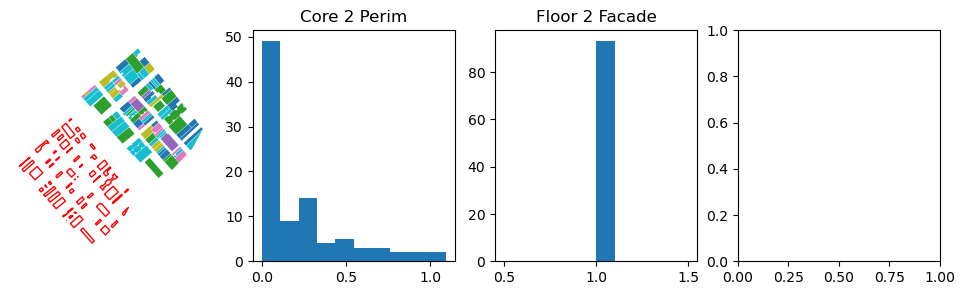

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0] = umi_test.visualize_2d(ax=ax[0])
ax[1].hist(umi_test.gis_features_df["core_2_perim"])
ax[1].set_title("Core 2 Perim")
ax[2].hist(umi_test.gis_features_df["floor_2_facade"])
ax[2].set_title("Floor 2 Facade")
# ax[3].hist(umi_test.gis_features_df["roof_2_footprint"])
# ax[3].set_title("Roof/Ground 2 Footprint")
plt.show()


## 3. Open UMI v1 project

We will be running the Florianopolis seed with a variety of different epw files.

The chosen ones:
- 0B: cityidx_0264_VEN_--CARACAS
- 2A: Florianopolis (baseline)
- 4C: cityidx_0725_ESP_--Avila
- 7: cityidx_0305_MNG_--ULAANBATAAR

In [3]:
month_map = {
    "january": 744,
    "february": 672,
    "march": 744,
    "april": 720,
    "may": 744,
    "june": 720,
    "july": 744,
    "august": 744,
    "september": 720,
    "october": 744,
    "november": 720,
    "december": 744,
}
sum(list(month_map.values()))


8760

In [4]:
areas = umi_test.gis_features_df[["building_id", "footprint_area", "floor_count"]]
areas["tfa"] = areas["footprint_area"] * areas["floor_count"]
areas = areas.sort_values("building_id")
areas.set_index("building_id", inplace=True)
areas.head()

,footprint_area,floor_count,tfa
building_id,,,
027e56c0-34b7-714a-9e97-08db9fc15045,46.028564,4.0,184.114256
095ce372-1a56-5744-a7be-6350e9250916,92.098678,1.0,92.098678
0a11abfe-8782-a241-a8c0-20bd08f70dbb,72.562633,2.0,145.125265
11ed3672-e6fb-354f-9f76-fc3e8fbcd50b,194.838924,2.0,389.677849
12f9435e-d5cc-bd40-9efa-c6ec52a9f804,82.491006,2.0,164.982013


In [11]:
cops = umi_test.gis_features_df[["building_id", "template_name"]]
cops = cops.merge(
    umi_test.template_features_df[
        [umi_test.template_name_col, "cop_heating", "cop_cooling"]
    ],
    left_on="template_name",
    right_on=umi_test.template_name_col,
)
cops = cops.sort_values("building_id")
cops.set_index("building_id", inplace=True)
cops.head()

,template_name,TemplateName,cop_heating,cop_cooling
building_id,,,,
027e56c0-34b7-714a-9e97-08db9fc15045,RefBldgQuickServiceRestaurantPost1980_v1.4_7.2...,RefBldgQuickServiceRestaurantPost1980_v1.4_7.2...,0.692,2.37
095ce372-1a56-5744-a7be-6350e9250916,RefBldgStand-aloneRetailPost1980_v1.4_7.2_2A_U...,RefBldgStand-aloneRetailPost1980_v1.4_7.2_2A_U...,0.692,2.37
0a11abfe-8782-a241-a8c0-20bd08f70dbb,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...,0.692,2.37
11ed3672-e6fb-354f-9f76-fc3e8fbcd50b,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...,0.692,2.37
12f9435e-d5cc-bd40-9efa-c6ec52a9f804,RefBldgStand-aloneRetailPost1980_v1.4_7.2_2A_U...,RefBldgStand-aloneRetailPost1980_v1.4_7.2_2A_U...,0.692,2.37


In [13]:
# Get monthly energy data
def get_monthly(h):
    h.set_index("Building Id", inplace=True)
    h = h[[str(x) for x in range(1, 8761)]]
    h.columns = h.columns.astype("int")
    c = 0
    for month, hours in month_map.items():
        h[month] = h.iloc[:, c : c + hours].sum(axis=1)
        c += hours
    return h[list(month_map.keys())]


seeds = ["caracas", "florianopolis", "avila", "ulaanbataar"]
simulated_umi_path = (
    Path(os.path.normpath(os.getcwd() + os.sep + os.pardir))
    / "umi_data"
    / "Florianopolis"
)
hourly_data_path = Path("data") / "SeedValidation"
heating = {}
cooling = {}
for city in seeds:
    h = pd.read_csv(hourly_data_path / f"seed_{city}_heating.csv")
    h = get_monthly(h)
    # Normalize by area
    h = h.divide(areas["tfa"], axis=0)
    # Get demand
    heating[city] = h.multiply(cops["cop_heating"], axis=0)
    c = pd.read_csv(hourly_data_path / f"seed_{city}_cooling.csv")
    c = get_monthly(c)
    c = c.divide(areas["tfa"], axis=0)
    cooling[city] = c.multiply(cops["cop_cooling"], axis=0)

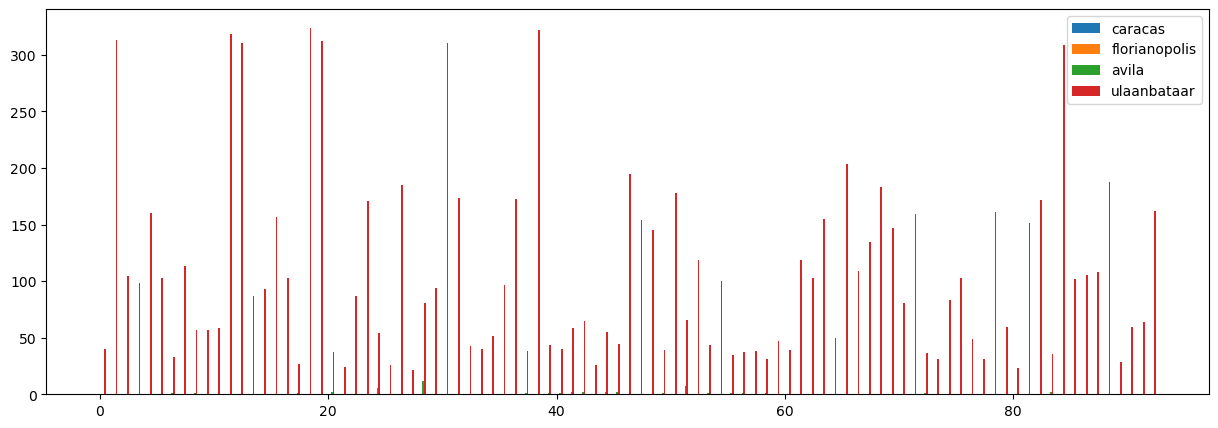

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
mlt = 0
width = 0.15
x = np.arange(93)
for city, vals in heating.items():
    offset = width * mlt
    rects = ax.bar(x + offset, vals.sum(axis=1), width, label=city)
    mlt += 1
plt.legend()


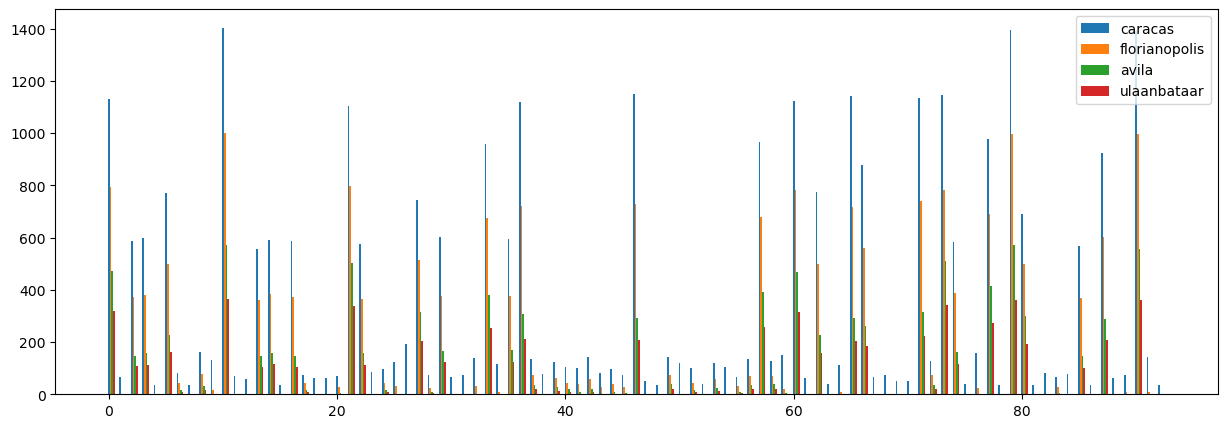

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
mlt = 0
for city, vals in cooling.items():
    offset = width * mlt
    rects = ax.bar(x + offset, vals.sum(axis=1), width, label=city)
    mlt += 1
plt.legend()


### Fetch all the shoeboxes

In [10]:
from pyumi import UmiProject
from pyumi.shoeboxer import ShoeBox
from pyumi.umi_project import ShoeBoxCollection


In [11]:
def fetch_shoeboxes(simulated_shoeboxdf):
    shoeboxes = ShoeBoxCollection()
    df = simulated_shoeboxdf.reset_index().groupby("ShoeboxPath").first().reset_index()
    for _, row in df.iterrows():
        idf_path = row["ShoeboxPath"]
        shoeboxes[idf_path] = ShoeBox(idf_path)
    return shoeboxes


def set_energy_path(simulated_shoeboxdf, new_path):
    old_paths = simulated_shoeboxdf["ShoeboxPath"]
    new_paths = []

    new_path = os.path.normpath(new_path)
    to_match = new_path.split(os.sep)[-1]
    idx = old_paths[0].split("\\").index(to_match)
    for p in old_paths:
        p = p.split("\\")
        new_p = new_path
        for i in range(idx + 1, len(p)):
            new_p = os.path.join(new_p, p[i])
        new_paths.append(new_p)

    simulated_shoeboxdf["ShoeboxPath"] = new_paths
    return simulated_shoeboxdf

In [12]:
simulated_umi_path = "D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/Florianopolis_Baseline_simulated.umi"
energy_path = "D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/hourly/eplus"
simulated_umi = UmiProject.open(simulated_umi_path)


In [13]:
df = pd.DataFrame.from_dict(simulated_umi.sdl_common["shoebox-weights"])
simulated_shoeboxdf = df.merge(
    simulated_umi.gdf_world, how="left", left_on="ParentBuildingId", right_on="id"
)
simulated_shoeboxdf = set_energy_path(simulated_shoeboxdf, energy_path)
simulated_shoeboxdf.head()


,ParentBuildingId,PerimeterAreaWeight,CoreAreaWeight,PerimeterArea,CoreArea,Orientation,ClusterId,Roof2FloorRatio,Ground2FloorRatio,Floor2Fac,...,Height,Name,Occupancy,TemplateName,UseType,WwrE,WwrN,WwrS,WwrW,geometry
0,b8848bab-34b8-6b44-bb4c-43deca1051a6,5.817445,0.0,240.45439,0.0,West,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."
1,b8848bab-34b8-6b44-bb4c-43deca1051a6,3.878297,0.0,240.45439,0.0,West,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."
2,b8848bab-34b8-6b44-bb4c-43deca1051a6,3.878297,0.0,240.45439,0.0,South,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."
3,b8848bab-34b8-6b44-bb4c-43deca1051a6,5.817445,0.0,240.45439,0.0,South,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."
4,b8848bab-34b8-6b44-bb4c-43deca1051a6,1.939148,0.0,240.45439,0.0,South,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."


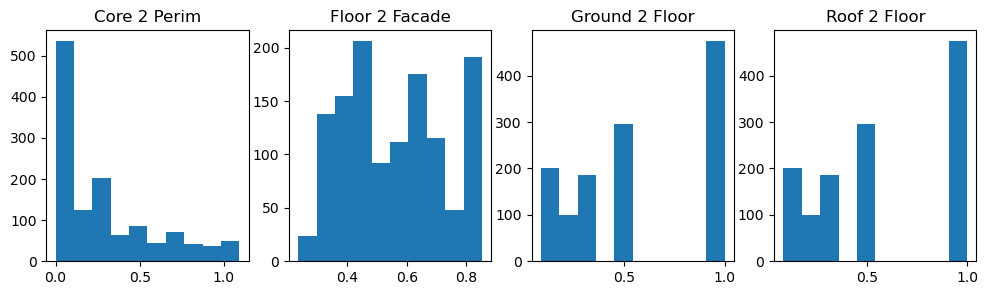

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].hist(simulated_shoeboxdf["Core2Perimeter"])
ax[0].set_title("Core 2 Perim")
ax[1].hist(simulated_shoeboxdf["Floor2Fac"])
ax[1].set_title("Floor 2 Facade")
ax[2].hist(simulated_shoeboxdf["Ground2FloorRatio"])
ax[2].set_title("Ground 2 Floor")
ax[3].hist(simulated_shoeboxdf["Roof2FloorRatio"])
ax[3].set_title("Roof 2 Floor")
plt.show()


In [25]:
print(simulated_shoeboxdf.shape)
df = simulated_shoeboxdf.groupby("ShoeboxPath", as_index=False).first()
print(df.shape)


(1255, 25)
(64, 25)


In [10]:
simulated_shoeboxes = fetch_shoeboxes(df)


In [11]:
from archetypal import settings
import subprocess

settings.energyplus_location = Path("D:\EnergyPlusV22-2-0")
settings.ep_version = "22.2.0"


def convert(fullpath):
    # Define the command and its arguments
    output_directory, path = os.path.split(fullpath)
    cmd = (
        settings.energyplus_location / f"energyplus{'.exe' if os.name == 'nt' else ''}"
    )
    args = ["--convert-only", "--output-directory", output_directory, fullpath]

    # TODO change location of idf

    # Run the command
    with subprocess.Popen(
        [cmd] + args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    ) as proc:
        for line in proc.stdout:
            print(line.strip())
        exit_code = proc.wait()

    # Check if the command was successful
    if exit_code == 0:
        pass
    else:
        print(f"Command failed with exit code {exit_code}.")
        raise RuntimeError(f"Failed to convert EpJSON to IDF.")


# def setup_update(shoeboxes_dict, updated_directory):
#     # Make list of files to convert
#     files_to_convert = list(shoeboxes_dict.keys())
#     with open(Path(updated_directory, "to_convert.lst"), "w") as f:
#         f.writelines(line + '\n' for line in files_to_convert)
# setup_update(simulated_shoeboxes, "D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/eplus/converted")

### Load all the eplus outputs

In [53]:
ENERGY_DIR = "ml-for-bem/umi/energy"
ENERGY_CSV_OUTPUTS = [
    "Date/Time",
    # "PERIM:Zone People Total Heating Energy [J](Hourly)",
    # "CORE:Zone People Total Heating Energy [J](Hourly)",
    # "PERIM:Zone Lights Electric Energy [J](Hourly)",
    # "CORE:Zone Lights Electric Energy [J](Hourly)",
    # "PERIM:Zone Electric Equipment Electric Energy [J](Hourly)",
    # "CORE:Zone Electric Equipment Electric Energy [J](Hourly)",
    # "PERIM:Zone Windows Total Transmitted Solar Radiation Energy [J](Hourly)",
    # "CORE:Zone Windows Total Transmitted Solar Radiation Energy [J](Hourly)",
    # "PERIM:Zone Mean Radiant Temperature [C](Hourly)",
    # "CORE:Zone Mean Radiant Temperature [C](Hourly)",
    # "PERIM:Zone Mean Air Temperature [C](Hourly)",
    # "PERIM:Zone Operative Temperature [C](Hourly)",
    # "CORE:Zone Mean Air Temperature [C](Hourly)",
    # "CORE:Zone Operative Temperature [C](Hourly)",
    # "PERIM:Zone Infiltration Total Heat Loss Energy [J](Hourly)",
    # "PERIM:Zone Infiltration Total Heat Gain Energy [J](Hourly)",
    # "PERIM:Zone Infiltration Air Change Rate [ach](Hourly)",
    # "CORE:Zone Infiltration Total Heat Loss Energy [J](Hourly)",
    # "CORE:Zone Infiltration Total Heat Gain Energy [J](Hourly)",
    # "CORE:Zone Infiltration Air Change Rate [ach](Hourly)",
    # "PERIM:Zone Air Temperature [C](Hourly)",
    # "PERIM:Zone Air Relative Humidity [%](Hourly)",
    # "CORE:Zone Air Temperature [C](Hourly)",
    # "CORE:Zone Air Relative Humidity [%](Hourly)",
    "PERIM IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Energy [J](Hourly)",
    "PERIM IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Energy [J](Hourly)",
    # "PERIM IDEAL LOADS AIR:Zone Ideal Loads Zone Total Heating Energy [J](Hourly)",
    "CORE IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Energy [J](Hourly)",
    "CORE IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Energy [J](Hourly)",
    # "CORE IDEAL LOADS AIR:Zone Ideal Loads Zone Total Heating Energy [J](Hourly)",
    # "DHW PERIM:Water Use Equipment Heating Energy [J](Hourly)",
    # "DHW CORE:Water Use Equipment Heating Energy [J](Hourly)",
]


def fetch_raw_shoebox_results(idf_path):
    csv_path = idf_path.replace("idf", "csv")
    try:
        pandas_df = pd.read_csv(csv_path)
        pandas_df.columns = pandas_df.columns.str.strip()
        cols = pandas_df.columns.tolist()
    except Exception as e:
        print(f"Error opening energy csv: {csv_path}")
        raise e

    # TODO: if there is no water use equipment this is not added to the idf and is not in the csv output
    # Temporary fix to add zeros if there is a missing entry
    if len(cols) != len(ENERGY_CSV_OUTPUTS):
        # print(f"Missing some outputs for {csv_path}")
        for col in ENERGY_CSV_OUTPUTS:
            if col not in cols:
                print(
                    f"Could not find results for {col} in {csv_path}. Assuming no energy use (zeros)."
                )
                pandas_df[col] = 0
        # reorganize columns in correct order
        pandas_df = pandas_df[ENERGY_CSV_OUTPUTS]
    new_cols = []
    for c in pandas_df.columns:
        if "[J]" in c:
            pandas_df[c] = pandas_df[c] * JOULES_TO_KWH
        c = c.split(" [")[0]
        new_cols.append(c)
    pandas_df.columns = new_cols
    return pandas_df

In [58]:
# Check with one shoebox
edf = fetch_raw_shoebox_results(simulated_shoeboxdf["ShoeboxPath"][0])
edf.describe()


,PERIM IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Energy,PERIM IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Energy,CORE IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Energy,CORE IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Energy
count,8760.0,8760.000000,8760.0,8760.000000
mean,0.0,0.089042,0.0,0.060820
std,0.0,0.121163,0.0,0.079270
min,0.0,0.000000,0.0,0.000000
25%,0.0,0.000000,0.0,0.000000
50%,0.0,0.000000,0.0,0.000000
75%,0.0,0.166338,0.0,0.121131
max,0.0,0.492293,0.0,0.216114


In [61]:
# Get results for all shoeboxes
raw_simulated_umi_results = {}
for path in simulated_shoeboxdf["ShoeboxPath"]:
    raw_simulated_umi_results[path] = fetch_raw_shoebox_results(path)


## 4. Run surrogate for built v2 shoeboxes & compare

In [3]:
from ml.predict import predict_ubem
from lightning.pytorch import Trainer
from ml.data import BuildingDataModule
from ml.surrogate import Surrogate

Couldn't import dot_parser, loading of dot files will not be possible.


c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\torchaudio\backend\utils.py:66: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [4]:
# Download climate array
import boto3

climate_array_path = "data/epws/global_climate_array.npy"

# client = boto3.client('s3')
# bucket = "ml-for-bem"
# experiment_name = "weather"

# client.download_file(
#                 bucket,
#                 "weather/temp/global_climate_array.npy",
#                 climate_array_path,
#             )

In [5]:
bucket = "ml-for-bem"
remote_experiment = "full_climate_zone/v5"
local_data_dir = "data/lightning"

dm = BuildingDataModule(
        bucket=bucket,
        remote_experiment=remote_experiment,
        data_dir=local_data_dir,
        climate_array_path=climate_array_path,
        batch_size=128,
        val_batch_mult=8,
    )

dm.prepare_data()
dm.setup(stage=None)
target_transform = dm.target_transform
weather_transform = dm.weather_transform
space_config = dm.space_config

In [7]:
"""
Hyperparameters:
"""
lr = 1e-2  # TODO: larger learning rate for larger batch size on multi-gpu?
lr_gamma = 0.95
net_config = "Small"
latent_factor = 4
energy_cnn_feature_maps = 512
energy_cnn_n_layers = 3
energy_cnn_n_blocks = 12
n_climate_timeseries = 7
n_building_timeseries = 3
timeseries_channels_per_input = n_climate_timeseries + n_building_timeseries
static_features_per_input = 52
timeseries_channels_per_output = 4
timeseries_steps_per_output = 12

surrogate = Surrogate(
    lr=lr,
    lr_gamma=lr_gamma,
    target_transform=target_transform,
    weather_transform=weather_transform,
    space_config=space_config,
    net_config=net_config,
    latent_factor=latent_factor,
    energy_cnn_feature_maps=energy_cnn_feature_maps,
    energy_cnn_n_layers=energy_cnn_n_layers,
    energy_cnn_n_blocks=energy_cnn_n_blocks,
    timeseries_channels_per_input=timeseries_channels_per_input,
    static_features_per_input=static_features_per_input,
    timeseries_channels_per_output=timeseries_channels_per_output,
    timeseries_steps_per_output=timeseries_steps_per_output,
)

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
        precision="bf16-mixed",
    )

features, schedules, climate = umi_test.prepare_for_surrogate()

predictions = predict_ubem(
        trainer=trainer,
        surrogate=surrogate,
        features=features,
        schedules=schedules,
        climate=climate,
        batch_size=32,
    )

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


Predicting DataLoader 0:  19%|█▊        | 5/27 [02:20<10:16,  0.04it/s]

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


AttributeError: 'NoneType' object has no attribute 'cpu'

In [8]:
umi_test.shoeboxes_df.columns

Index(['building_id', 'orientation', 'roof_2_footprint', 'ground_2_footprint',
       'floor_name', 'wwr', 'height', 'footprint_area', 'core_2_perim',
       'floor_2_facade', 'building_perimeter', 'floor_count', 'template_name',
       'north_weight', 'east_weight', 'south_weight', 'west_weight', 'bottom',
       'top', 'middle', 'exclusive', 'PeopleDensity', 'LightingPowerDensity',
       'EquipmentPowerDensity', 'Infiltration', 'VentilationPerArea',
       'VentilationPerPerson', 'VentilationMode', 'HeatingSetpoint',
       'CoolingSetpoint', 'humid_max', 'humid_min', 'sat_max', 'sat_min',
       'RecoverySettings', 'EconomizerSettings', 'FacadeRValue', 'FacadeMass',
       'RoofRValue', 'RoofMass', 'SlabRValue', 'WindowShgc', 'WindowUValue',
       'visible_transmittance', 'TemplateName', 'template_idx', 'cop_heating',
       'cop_cooling', 'oriented_weight', 'floor_weight', 'weight', 'shading_0',
       'shading_1', 'shading_2', 'shading_3', 'shading_4', 'shading_5',
       'shadi

## 5. Compare monthly results

## Comparing epjson shoeboxer with umi outputs

In [55]:
parent_ids = simulated_shoeboxdf[
    simulated_shoeboxdf["ShoeboxPath"] == df["ShoeboxPath"][0]
]["ParentBuildingId"].unique()

In [68]:
n_sbs = simulated_shoeboxdf[
    simulated_shoeboxdf["ParentBuildingId"].isin(parent_ids)
].shape[0]
n_idfs = (
    simulated_shoeboxdf[simulated_shoeboxdf["ParentBuildingId"].isin(parent_ids)][
        "ShoeboxPath"
    ]
    .unique()
    .shape[0]
)

In [69]:
f"for {len(parent_ids)} buildings", f"{n_sbs} Shoeboxes", f"and {n_idfs} .idf files"


('for 27 buildings', '471 Shoeboxes', 'and 56 .idf files')

In [116]:
g0df = (
    simulated_shoeboxdf[simulated_shoeboxdf["ClusterId"] == "Group0"][
        [
            "ParentBuildingId",
            "Orientation",
            "ShoeboxPath",
            "PerimeterAreaWeight",
            "CoreAreaWeight",
            "PerimeterArea",
            "CoreArea",
            "Roof2FloorRatio",
            "Ground2FloorRatio",
            "Floor2Fac",
            "Core2Perimeter",
        ]
    ].sort_values(["ParentBuildingId", "Orientation"])
    # .iloc[:20]
)
g0df["ShoeboxPath"] = g0df.ShoeboxPath.apply(lambda x: "-".join(x.split("\\")[-3:]))
g0df.groupby(["Orientation", "ShoeboxPath"]).count()

ParentBuildingId  PerimeterAreaWeight  \
Orientation ShoeboxPath                                                       
East        SAMPLE10-40-SAMPLE10.idf                12                   12   
            SAMPLE11-40-SAMPLE11.idf                14                   14   
            SAMPLE12-40-SAMPLE12.idf                11                   11   
            SAMPLE13-40-SAMPLE13.idf                17                   17   
            SAMPLE14-40-SAMPLE14.idf                24                   24   
...                                                ...                  ...   
West        SAMPLE60-40-SAMPLE60.idf                 6                    6   
            SAMPLE61-40-SAMPLE61.idf                 2                    2   
            SAMPLE62-40-SAMPLE62.idf                11                   11   
            SAMPLE63-40-SAMPLE63.idf                 3                    3   
            SAMPLE9-40-SAMPLE9.idf                   2                    2   

                                      CoreAreaWeight  PerimeterArea  CoreArea  \
Orientation ShoeboxPath                                                         
East        SAMPLE10-40-SAMPLE10.idf              12             12        12   
            SAMPLE11-40-SAMPLE11.idf              14             14        14   
            SAMPLE12-40-SAMPLE12.idf              11             11        11   
            SAMPLE13-40-SAMPLE13.idf              17             17        17   
            SAMPLE14-40-SAMPLE14.idf              24             24        24   
...                                              ...            ...       ...   
West        SAMPLE60-40-SAMPLE60.idf               6              6         6   
            SAMPLE61-40-SAMPLE61.idf               2              2         2   
            SAMPLE62-40-SAMPLE62.idf              11             11        11   
            SAMPLE63-40-SAMPLE63.idf               3              3         3   
            SAMPLE9-40-SAMPLE9.idf                 2              2         2   

                                      Roof2FloorRatio  Ground2FloorRatio  \
Orientation ShoeboxPath                                                    
East        SAMPLE10-40-SAMPLE10.idf               12                 12   
            SAMPLE11-40-SAMPLE11.idf               14                 14   
            SAMPLE12-40-SAMPLE12.idf               11                 11   
            SAMPLE13-40-SAMPLE13.idf               17                 17   
            SAMPLE14-40-SAMPLE14.idf               24                 24   
...                                               ...                ...   
West        SAMPLE60-40-SAMPLE60.idf                6                  6   
            SAMPLE61-40-SAMPLE61.idf                2                  2   
            SAMPLE62-40-SAMPLE62.idf               11                 11   
            SAMPLE63-40-SAMPLE63.idf                3                  3   
            SAMPLE9-40-SAMPLE9.idf                  2                  2   

                                      Floor2Fac  Core2Perimeter  
Orientation ShoeboxPath                                          
East        SAMPLE10-40-SAMPLE10.idf         12              12  
            SAMPLE11-40-SAMPLE11.idf         14              14  
            SAMPLE12-40-SAMPLE12.idf         11              11  
            SAMPLE13-40-SAMPLE13.idf         17              17  
            SAMPLE14-40-SAMPLE14.idf         24              24  
...                                         ...             ...  
West        SAMPLE60-40-SAMPLE60.idf          6               6  
            SAMPLE61-40-SAMPLE61.idf          2               2  
            SAMPLE62-40-SAMPLE62.idf         11              11  
            SAMPLE63-40-SAMPLE63.idf          3               3  
            SAMPLE9-40-SAMPLE9.idf            2               2  

[99 rows x 9 columns]